## Test

In [68]:
# !pip install cv2
# !pip install moviepy
# !pip install mediapipe  
import cv2
import mediapipe as mp
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns  
from mpl_toolkits.mplot3d import Axes3D # 3D 시각화

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_face_mesh = mp.solutions.face_mesh

In [180]:
# PATH = './data'
PATH = './data/backup/tic'
# video_data = os.path.join(PATH, '40.mp4') 
video_data = os.path.join(PATH, '24.mp4') 
cap = cv2.VideoCapture(video_data) #<- video data  / streaming data -> cv2.VideoCapture(0)

## 불러온 비디오 파일 정보 출력
video_info = {
    'name' : video_data.split('/')[-1].split('.')[0],
    'path' : video_data,
    'fps' : cap.get(cv2.CAP_PROP_FPS),
    'total frame' : int(cap.get(cv2.CAP_PROP_FRAME_COUNT)), # 프레임수
    'width' : int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), # 가로 길이
    'height' : int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)), # 세로 길이
    "running_time('s)" : int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) / int(cap.get(cv2.CAP_PROP_FPS))
}
print(f"Video Information : {video_info}")

#여러 지점 좌표
landmark_dict = {
    #왼쪽눈
    'L_eye' : [33, 246, 161, 160, 159, 148, 157, 173, 133, 155, 154, 153, 145, 144, 163, 7], #시계방향 9시부터 시작
    #오른쪽눈
    'R_eye' : [369, 398, 384, 385, 386, 387, 388, 466, 263, 249, 390, 373, 374, 380, 381, 382], #시계방향 9시부터 시작
    #왼쪽 눈동자
    'L_iris' : [470, 471,469, 472, 468], #위에서부터 Up, Left, Right, Down, Center position
    #오른쪽 눈동자
    'R_iris' : [475, 476, 474, 477, 473],
    #왼쪽 눈썹
    'L_eyebrow' : [70, 63, 105, 66, 107, 55, 65, 52 ,53, 46], #시계방향 9시부터 시작
    #오른쪽 눈섭
    'R_eyebrow' : [336, 296, 334, 293, 300, 276, 283, 282, 295 ,285], #시계방향 9시부터 시작
    #윗 입술
    'Up_lips' : [61, 185, 40, 39, 37, 0, 267, 269, 270, 409, 391, 308, 415, 310, 311, 312, 13, 82, 81, 80, 191, 78],#시계방향 9시부터 시작
    #아랫 입술
    'Down_lips' : [61, 78, 95, 88, 178, 87, 14, 317, 402, 318, 324, 308, 391, 375, 321, 405, 314, 17, 84, 181, 91, 146],#시계방향 9시부터 시작
    #입술 안
    'Inner_lips' : [78, 191, 80, 81, 82, 13, 312, 311, 310, 415, 308, 324, 318, 402, 317, 14, 87, 178, 88, 95],#시계방향 9시부터 시작
    #얼굴외곽
    'Outline_face' : 
        [234, 127, 162, 21, 54, 103, 67, 109, 10, 338, 297, 332, 284,
         251, 389, 356, 454, 323, 361, 288, 397, 365, 379, 378, 400,
         377, 152, 148, 175, 149, 150, 136, 172, 58, 132, 93]
} 

Video Information : {'name': '24', 'path': './data/backup/tic/24.mp4', 'fps': 24.0, 'total frame': 228, 'width': 1280, 'height': 720, "running_time('s)": 9.5}


In [184]:
## 얼굴 외곽 마스크 생성 방법
def face_outline_masking(results, landmark_dict, image):
    # 얼굴 외곽 정의한 것 가지고 얼굴 외곽 좌표 추출
    face_outline_coords = [
        (int(results.multi_face_landmarks[0].landmark[i].x * image.shape[1]),
        int(results.multi_face_landmarks[0].landmark[i].y * image.shape[0]))
        for i in landmark_dict['Outline_face']] 

    # 얼굴 외곽 마스크 생성
    mask = np.zeros_like(image)
    
    # 얼굴 부분을 빨간색으로 만들기
    cv2.fillPoly(mask, [np.array(face_outline_coords, dtype=np.int32)], (0, 0, 255))  # R : BGR 순서
    # cv2.fillPoly(mask, [np.array(face_outline_coords, dtype=np.int32)], (0, 255, 0))  # G : BGR 순서
    # cv2.fillPoly(mask, [np.array(face_outline_coords, dtype=np.int32)], (255, 0, 0))  # B : BGR 순서
    
    # 얼굴 마스크 적용
    masked_face = cv2.bitwise_and(image, mask)
    # 원본 영상에 얼굴 마스크 덧씌우기
    masked_image = cv2.addWeighted(image, 1, masked_face, 0.5, 0.1)  
    # 얼굴 영역 좌표 구하기
    x, y, w, h = cv2.boundingRect(np.array(face_outline_coords, dtype=np.int32))
    # 얼굴 내부 부분에 박스 그리기
    cv2.rectangle(masked_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    # 얼굴 마스크 적용
    masked_face = cv2.bitwise_and(masked_image, mask)
    # 원본 영상에 얼굴 마스크 덧씌우기
    masked_image = cv2.addWeighted(masked_image, 1, masked_face, 0.8, 0.1)
    return masked_face, masked_image


## hanging_cnt_v1 : z-score normal 후 부호를 이용해서 머리흔들림이 심한 프레임에 대해서 부호로 머리흔들림 스코어링 선정 -> 잘안될떄가 있다.
def hanging_cnt_v1(hanging_frame):
    #움직임에 대한 변화량을 z_score_normalization 함
    movement_array = z_score_norm(np.array(hanging_frame)[:,1])
    # print(f"sign change check for z_score_movement : {np.sign(movement_array)}")
    # movement_array = z_score_norm(hanging_frame[:,1])

    # 부호 변경 횟수를 카운트할 변수
    sign_change_count = 0

    # 이전 움직임의 부호 초기화
    previous_sign = np.sign(movement_array[0])

    # 배열을 순회하면서 부호 변경 횟수를 계산
    for i in range(1, len(movement_array)):
        current_sign = np.sign(movement_array[i])
        
        # 부호가 변경되면 카운트 증가
        if current_sign != previous_sign:
            # 다음 움직임이 다시 원래 부호로 돌아올 때만 카운트 증가
            if i + 1 < len(movement_array) and np.sign(movement_array[i + 1]) == previous_sign:
                # print(hanging_frame[])
                sign_change_count += 1
        
        previous_sign = current_sign

    print(f"v1_틱 증상  : {sign_change_count}")

## hanging_cnt_v2 : 프레임의 대한 범위를 지정해서 하나의 그룹으로 묶는다. 단점 : 프레임 범위인 threshold를 정해줘야함.
def hanging_cnt_v2(frames, threshold):
    # 그룹을 저장할 리스트
    groups = []

    # 현재 그룹에 속하는 프레임들을 저장할 리스트
    current_group = [frames[0]]

    # 프레임별로 그룹을 묶음
    for i in range(1, len(frames)):
        # 현재 프레임과 이전 프레임의 차이가 10프레임을 넘지 않으면 같은 그룹으로 묶음
        if frames[i] - frames[i-1] <= 10:
            current_group.append(frames[i])
        else:
            # 차이가 10프레임을 넘으면 새로운 그룹 시작
            groups.append(current_group)
            current_group = [frames[i]]

    # 마지막 그룹 추가
    groups.append(current_group)

    # 결과 출력
    print(f"v2_틱 증상 : {len(groups)}번")


In [185]:
### Configure Varaible 
## Video Setting
cap = cv2.VideoCapture(video_data) # video load 
drawing_spec = mp_drawing.DrawingSpec(thickness = 3, circle_radius = 3)

## 얼굴 랜드마크 검출 객체
landmark = []

## fps 탐지
import time
start_time = time.time()

## 머리 흔들기 객체
hanging_cnt = 0
hanging_threshold = 0.025
hanging_frame = []

### Video Action Code
with mp_face_mesh.FaceMesh(  
        max_num_faces=1, #최대 검출 얼굴 개수
        refine_landmarks=True, # 눈과 입술 주변 랜드마크 정교하게 검출시 True
        min_detection_confidence=0.5, #최소 Detection 기준
        min_tracking_confidence=0.5, #최소 traicking 기준
        static_image_mode=True) as face_mesh:
    frame = 1
    while cap.isOpened():
        # print(f"frame : {frame} frame")
        
        ret, image = cap.read()
        # 현재 시간과 이전 시간과의 경과 시간 계산
        elapse_time = time.time() - start_time
        
        # 현재 fps 계산
        fps = 1 / elapse_time
        
        # if not ret:
        #     print("웹캠을 찾을 수 없습니다.")
        #     # 비디오 파일의 경우 'continue'를 사용하시고, 웹캠에 경우에는 'break'를 사용하세요
        #     continue
        #     # break
        if not ret: #영상 더 가지고 올게 없으면 끝내기
            cv2.destroyAllWindows()
            cv2.waitKey(1)
            break
        else: #영상 진행 중일때 
            # 필요에 따라 성능 향상을 위해 이미지 작성을 불가능함으로 기본 설정합니다.
            image.flags.writeable = False
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            results = face_mesh.process(image)

            # 이미지 위에 얼굴 그물망 주석을 그립니다.
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            if results.multi_face_landmarks:
                for face_landmarks in results.multi_face_landmarks:
                    mp_drawing.draw_landmarks(
                        image=image,
                        landmark_list=face_landmarks,
                        connections=mp_face_mesh.FACEMESH_TESSELATION,
                        landmark_drawing_spec=None,
                        connection_drawing_spec=mp_drawing_styles
                        .get_default_face_mesh_tesselation_style())
                    mp_drawing.draw_landmarks(
                        image=image,
                        landmark_list=face_landmarks,
                        connections=mp_face_mesh.FACEMESH_CONTOURS,
                        landmark_drawing_spec=None,
                        connection_drawing_spec=mp_drawing_styles
                        .get_default_face_mesh_contours_style())
                    mp_drawing.draw_landmarks(
                        image=image,
                        landmark_list=face_landmarks,
                        connections=mp_face_mesh.FACEMESH_IRISES,
                        landmark_drawing_spec=None,
                        connection_drawing_spec=mp_drawing_styles
                        .get_default_face_mesh_iris_connections_style())
                    
                    #masking 및 박스 플랏 이미지
                    masked_face, masked_image = face_outline_masking(results, landmark_dict, image)
                    
                    # 프레임별 변화량에 따른 변화도 측정
                    # 현재 랜드마크 좌표
                    current_landmark = np.array([(point.x, point.y, point.z) for point in face_landmarks.landmark])
                    if frame == 1: #첫 번쨰 프레임일떄는
                        # 현재 랜드마크를 이전 랜드마크로만 저장
                        previous_landmark = current_landmark
                        tag_detected = False
                        continue
                    else:
                        # 모든 랜드마크의 변화량 계산
                        distances = np.linalg.norm(np.abs(current_landmark - previous_landmark), axis=1)
                        # 평균변화량 출력 : Heuristic threshold Setting 0.05  
                        if np.mean(distances) > hanging_threshold:
                            print(f"Landmark Movement|frame :{np.mean(distances)}|{frame}")
                            hanging_frame.append([frame, np.mean(distances)])
                            tag_detected = True 
                        else:
                            tag_detected = False
                        # 현재 랜드마크를 이전 랜드마크로 저장
                        previous_landmark = current_landmark
            try:
                landmark.append(results)        
            except TypeError:
                continue
            # FPS 표시
            cv2.putText(masked_image, f"FPS : {fps:.2f}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 1)
            
            # 얼굴 큰 흔들림 태그 감지시 메시지 추가
            if tag_detected:
                cv2.putText(masked_image, "Head hadly shake detect!!", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2, cv2.LINE_AA)
            
            # 보기 편하게 이미지를 좌우 반전합니다.
            # edge_image = cv2.Canny(image, 100, 255)
            
            # cv2.imshow('MediaPipe Face Mesh(Puleugo)', image)
            cv2.imshow('MediaPipe Face Mesh(Puleugo)', masked_image)
            # cv2.imshow('MediaPipe Face Mesh(Puleugo)', frame_image)
            # 현재 시간 갱신
            start_time = time.time()
            
            
            # Esc 누르면 영상 종료
            if cv2.waitKey(5) & 0xFF == 27:
                #맥에서 opencv 안닫힐때 꿀팁
                cv2.destroyAllWindows()
                cv2.waitKey(1)
                cv2.waitKey(1)
                cv2.waitKey(1)
                cv2.waitKey(1)
                break
        frame += 1
cap.release()

hanging_cnt_v1(hanging_frame)
hanging_cnt_v2(np.array(hanging_frame)[:,0], threshold= 0.4)

Landmark Movement|frame :0.05602069006238882|17
Landmark Movement|frame :0.03313231910379909|20
Landmark Movement|frame :0.08968934362338561|21
Landmark Movement|frame :0.032889574642141435|24
Landmark Movement|frame :0.03677046254158263|26
Landmark Movement|frame :0.04221406945061226|27
Landmark Movement|frame :0.03629855055564235|28
Landmark Movement|frame :0.029821725750671983|33
Landmark Movement|frame :0.056837459621238505|105
Landmark Movement|frame :0.03084049710973043|106
Landmark Movement|frame :0.03816461737094435|113
Landmark Movement|frame :0.053371655903025395|119
Landmark Movement|frame :0.03321863184954991|120
Landmark Movement|frame :0.06731078730874884|121
Landmark Movement|frame :0.060838768411909314|122
Landmark Movement|frame :0.04917626736180759|123
Landmark Movement|frame :0.0466721192599013|125
Landmark Movement|frame :0.03727257546444131|128
Landmark Movement|frame :0.06706471608299457|129
Landmark Movement|frame :0.0353498607235696|132
v1_틱 증상  : 7
v2_틱 증상 : 2번

In [187]:
#랜드마크 처리 
### landmakr[frame].multi_face_landmarks[person_cnt].landamrk[landmark number(1~478)]
# print(frame_len, person_len, landmark_len)

frame_len = len(landmark) 
person_len = len(landmark[0].multi_face_landmarks) #사람 몇명인지
landmark_len = len(landmark[0].multi_face_landmarks[0].landmark)

landmark_arr = np.zeros((frame_len, person_len, landmark_len, 3))
# Landmark Data preprocessing
for frame_idx in range(frame_len):
    try:
        person_len = len(landmark[frame_idx].multi_face_landmarks) #사람 몇명인지
    except:
        continue
    for person_idx in range(person_len):
        try:
            landmark_len = len(landmark[frame_idx].multi_face_landmarks[person_idx].landmark)
        except:
            continue
        for landmark_idx in range(landmark_len):
            x,y,z, _= map(str, str(landmark[frame_idx].multi_face_landmarks[person_idx].landmark[landmark_idx]).split('\n'))
            landmark_arr[frame_idx, person_idx, landmark_idx] = x.split(' ')[-1],y.split(' ')[-1],z.split(' ')[-1] 

np.save(os.path.join('./data/np', video_info['name']), landmark_arr)
print(f"Saved numpy file : {os.path.join('./data/np', video_info['name'])}")
print(f"Arr shpae : {landmark_arr.shape}") #-> (Frame, Person Num, Landmark_index, position(x,y,z))    


Saved numpy file : ./data/np/24
Arr shpae : (202, 1, 478, 3)


In [188]:
# 랜드마크 arr to df
landmark_arr = np.load(f'./data/np/'+video_info['name']+'.npy')
reshaped_arr = landmark_arr[0,0].reshape(-1,3)
landmark_df = pd.DataFrame(reshaped_arr, columns=['X', 'Y', 'Z'])
landmark_df

,X,Y,Z
0,0.433889,0.500854,-0.026600
1,0.432783,0.431792,-0.048860
2,0.433378,0.449053,-0.026152
3,0.427978,0.381103,-0.035988
4,0.433228,0.415654,-0.051841
...,...,...,...
473,0.485137,0.353002,0.002894
474,0.495336,0.355495,0.002894
475,0.486434,0.338139,0.002894
476,0.475083,0.350430,0.002894


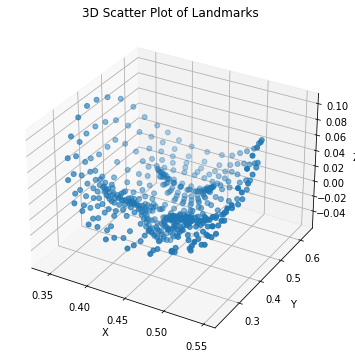

In [189]:
# 3D 산점도 그리기
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(landmark_df['X'], landmark_df['Y'], landmark_df['Z'], s=25, )  # s는 점의 크기를 나타냅니다.

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Scatter Plot of Landmarks')

plt.show()

landamark_arr shape : (202, 1, 478, 3)


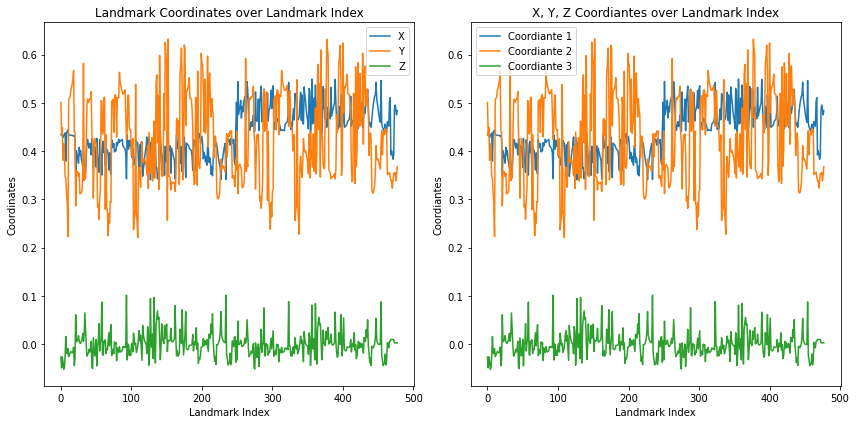

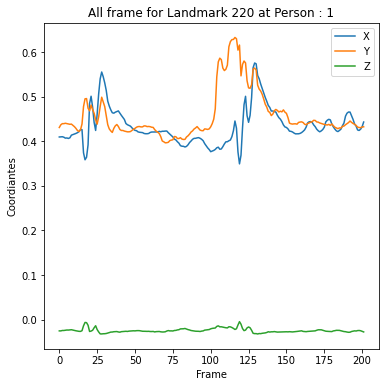

In [190]:
# landmark arr : (frame_index, person_index, landmark_index, (x,y,z))
# landmark_arr = np.load('./data/np/test2.npy')
landmark_arr = np.load(f'./data/np/'+video_info['name']+'.npy')
def landmark_analysis_plot(landmark_arr):
    print(f"landamark_arr shape : {landmark_arr.shape}")
    frame_idx, person_idx = 0, 0 #frame 별, 사람 별
    landmarks_person_frame = landmark_arr[frame_idx, person_idx] #frame별 x,y,z 좌표 변화
    num_landmarks = landmarks_person_frame.shape[0]

    #랜드마크 수의 변화를 나타내는 그래프
    plt.figure(figsize = (12,6))
    plt.subplot(121)
    plt.plot(range(num_landmarks), landmarks_person_frame[:, 0], label='X')
    plt.plot(range(num_landmarks), landmarks_person_frame[:, 1], label='Y')
    plt.plot(range(num_landmarks), landmarks_person_frame[:, 2], label='Z')
    plt.title('Landmark Coordinates over Landmark Index')
    plt.xlabel('Landmark Index')
    plt.ylabel('Coordinates')
    plt.legend()

    # x, y, z변화를 나타내는 그래프
    plt.subplot(122)
    for i in range(3): #landmark index별 x,y,z의 
        plt.plot(range(num_landmarks), landmarks_person_frame[:, i], label=f'Coordiante {i+1}')
    plt.title('X, Y, Z Coordiantes over Landmark Index')
    plt.xlabel('Landmark Index')
    plt.ylabel('Coordiantes')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    ## 전체 프레임 별 사람 별 특정 랜드마크에 대한 x,y,z 변화도 
    landmark_idx= 219 #220번쨰 랜드마크 

    plt.figure(figsize=(int(f"{landmark_arr.shape[1]*6}"),6))
    for person_idx in range(landmark_arr.shape[1]):
        plt.subplot(1, landmark_arr.shape[1], person_idx+1)
        x_coordiantes = landmark_arr[:, person_idx, landmark_idx, 0]
        y_coordiantes = landmark_arr[:, person_idx, landmark_idx, 1]
        z_coordiantes = landmark_arr[:, person_idx, landmark_idx, 2]
        plt.plot(range(landmark_arr.shape[0]), x_coordiantes, label=f'X')
        plt.plot(range(landmark_arr.shape[0]), y_coordiantes, label=f'Y')
        plt.plot(range(landmark_arr.shape[0]), z_coordiantes, label=f'Z')
        plt.title(f'All frame for Landmark {landmark_idx+1} at Person : {person_idx+1}')
        plt.xlabel('Frame')
        plt.ylabel(f'Coordiantes')
        plt.legend()
    plt.show()
    
            
landmark_analysis_plot(landmark_arr)

In [191]:
# landmark_arr = np.load('./data/np/test2.npy')
landmark_arr = np.load(f'./data/np/'+video_info['name']+'.npy')

print(landmark_arr.shape)


(202, 1, 478, 3)


In [192]:
# 삼각형 메쉬 데이터 면적 계산
def calculate_triangle_area(vertices):
    # 세점 A,B,C
    A, B, C = vertices
    
    #벡터 AB, AC 계산
    AB = B - A
    AC = C - A 
    
    #외적 계산
    cross_product = np.cross(AB, AC) 
    
    # 삼각형 넓이 계산
    area = 0.5 * np.linalg.norm(cross_product)
    
    return area
#부위의 모든 랜드마크 면적 계산 누적 함수 
def cal_area(landmark, landmark_dict, tag):
    # 각 점 x,y 좌표 추출
    try:
        iris_landmark = landmark[:, :, landmark_dict[tag], :]        
        print(f' iris_landmark shape : {iris_landmark.shape}')
        # 각 프레임별 사람별 면적 저장하기 
        area_fr_per = np.zeros((iris_landmark.shape[0], iris_landmark.shape[1]))
        # 각프레임별 루프
        for frame_idx in range(iris_landmark.shape[0]):
            #각 사람별 루프
            for person_idx in range(iris_landmark.shape[1]):
                # 각 랜드마크별로 루프
                mesh_vetrices = iris_landmark[frame_idx, person_idx, :, : ]
                total_area = 0. 
                for landmark_idx in range(1, iris_landmark.shape[2]-1):
                    vetrices = np.array([
                        iris_landmark[frame_idx, person_idx, 0, :],
                        iris_landmark[frame_idx, person_idx, landmark_idx, :],
                        iris_landmark[frame_idx, person_idx, landmark_idx+1, :],
                        ])
                    total_area += calculate_triangle_area(vetrices)
                area_fr_per[frame_idx, person_idx] = total_area
                      
    except:
        print('Error')

    print(f"{tag} area shape : {area_fr_per.shape}")

    return area_fr_per

L_eye_area = cal_area(landmark_arr, landmark_dict, 'L_eye')
R_eye_area = cal_area(landmark_arr, landmark_dict, 'R_eye')
L_iris_area = cal_area(landmark_arr, landmark_dict, 'L_iris')
R_iris_area = cal_area(landmark_arr, landmark_dict, 'R_iris')
L_eyebrow_area = cal_area(landmark_arr, landmark_dict, 'L_eyebrow')
R_eyebrow_area = cal_area(landmark_arr, landmark_dict, 'R_eyebrow')
Up_lips_area = cal_area(landmark_arr, landmark_dict, 'Up_lips')
Down_lips_area = cal_area(landmark_arr, landmark_dict, 'Down_lips')
Inner_lips_area = cal_area(landmark_arr, landmark_dict, 'Inner_lips')



 iris_landmark shape : (202, 1, 16, 3)
L_eye area shape : (202, 1)
 iris_landmark shape : (202, 1, 16, 3)
R_eye area shape : (202, 1)
 iris_landmark shape : (202, 1, 5, 3)
L_iris area shape : (202, 1)
 iris_landmark shape : (202, 1, 5, 3)
R_iris area shape : (202, 1)
 iris_landmark shape : (202, 1, 10, 3)
L_eyebrow area shape : (202, 1)
 iris_landmark shape : (202, 1, 10, 3)
R_eyebrow area shape : (202, 1)
 iris_landmark shape : (202, 1, 22, 3)
Up_lips area shape : (202, 1)
 iris_landmark shape : (202, 1, 22, 3)
Down_lips area shape : (202, 1)
 iris_landmark shape : (202, 1, 20, 3)
Inner_lips area shape : (202, 1)


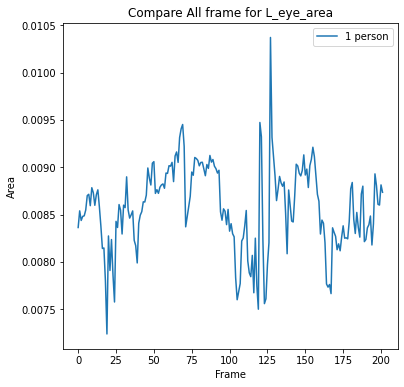

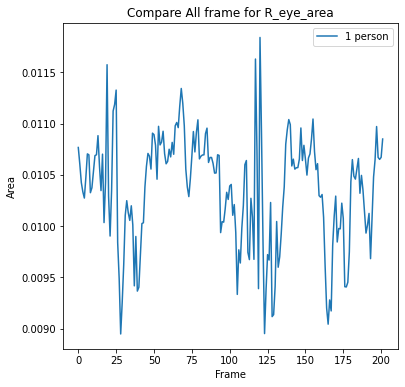

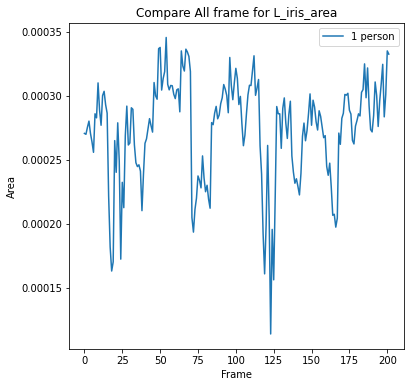

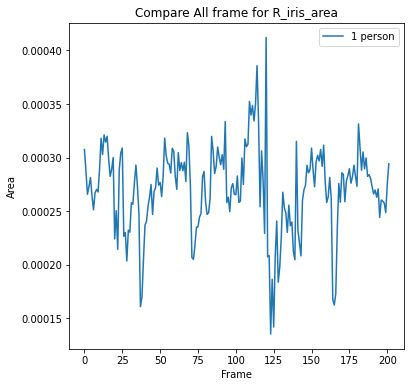

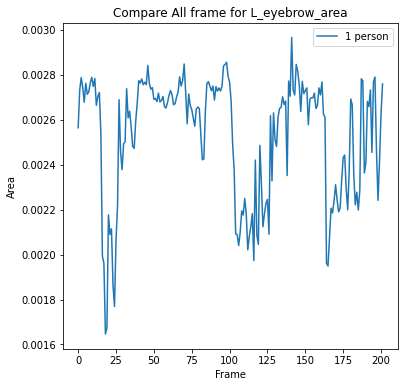

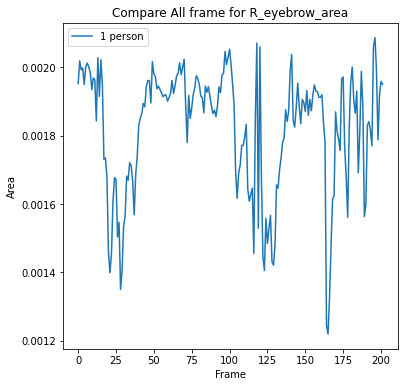

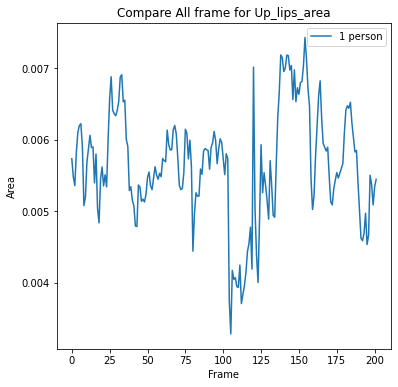

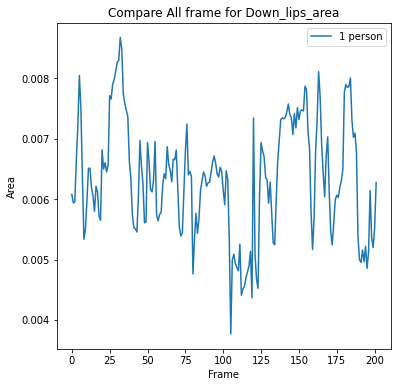

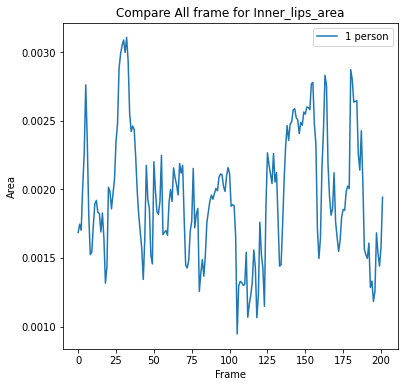

In [193]:
#영역 부피 저장 함수
def save_area(area_array, tag):
    np.save(
        os.path.join('./data/np', str(video_info['path'].split('/')[-1].split('.')[0] + f'_{tag}')),
        area_array
        )

# 면적에 따른 프레임별 분석
def area_analysis(landmark_arr, tag):
    plt.figure(figsize=(int(f"{landmark_arr.shape[1]*6}"),6))
    # 사람별로 프레임별 면적 계산
    for person_idx in range(landmark_arr.shape[1]):
        plt.subplot(1, landmark_arr.shape[1], person_idx+1)
        plt.plot(range(landmark_arr.shape[0]), landmark_arr[:,person_idx], label=f'{person_idx+1} person')
        plt.title(f'Compare All frame for {tag}')
        plt.xlabel('Frame')
        plt.ylabel(f'Area')
        plt.legend()
    plt.show()
    
def z_score_norm(arr):
    # z-score normalization
    mean_val = np.mean(arr)
    std_dev = np.std(arr)
    return (arr - mean_val) / std_dev

area_dict = {
    'L_eye_area' : L_eye_area,
    'R_eye_area' : R_eye_area,
    'L_iris_area' : L_iris_area,
    'R_iris_area' : R_iris_area,
    'L_eyebrow_area' : L_eyebrow_area,
    'R_eyebrow_area' : R_eyebrow_area,
    'Up_lips_area' : Up_lips_area,
    'Down_lips_area' : Down_lips_area,
    'Inner_lips_area' : Inner_lips_area
}


# area_dict = {
#     'L_eye_area' : z_score_norm(L_eye_area),
#     'R_eye_area' : z_score_norm(R_eye_area),
#     'L_iris_area' : z_score_norm(L_iris_area),
#     'R_iris_area' : z_score_norm(R_iris_area),
#     'L_eyebrow_area' : z_score_norm(L_eyebrow_area),
#     'R_eyebrow_area' : z_score_norm(R_eyebrow_area),
#     'Up_lips_area' : z_score_norm(Up_lips_area),
#     'Down_lips_area' : z_score_norm(Down_lips_area),
#     'Inner_lips_area' : z_score_norm(Inner_lips_area)
# }
for key, value in area_dict.items():
    save_area(value, key)
    area_analysis(value, key)



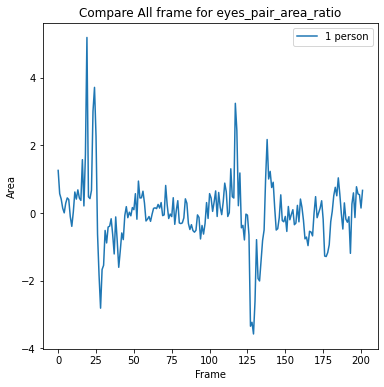

In [194]:
## 변화도가 큰 frame 구간 추출하기

eyes_pair_area_ratio = np.array([])
for i in range(len(area_dict['L_eye_area'])):
    eyes_pair_area_ratio = np.abs(area_dict['L_eye_area'] - area_dict['R_eye_area'])
    
area_analysis(z_score_norm(eyes_pair_area_ratio), 'eyes_pair_area_ratio')

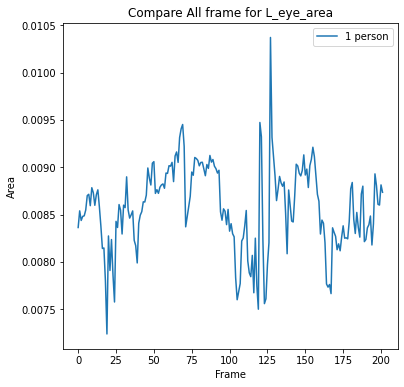

(202, 1)


In [195]:
# 초간격으로 변화량 계산
area_analysis(area_dict['L_eye_area'], 'L_eye_area') 
print(area_dict['L_eye_area'].shape)


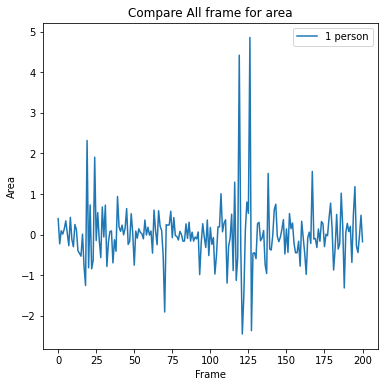

In [196]:
area = z_score_norm(area_dict['L_eye_area'])

fps = 24
num_frames = len(area)
seconds = num_frames / fps 

# L_eye_area의 변화량 계산
delta_L_eye_area = np.array([area[i+1] - area[i] for i in range(num_frames-1)])
area_analysis(delta_L_eye_area, 'area')

# # 초당 평균 변화량 계산
# average_change_per_second = sum(delta_L_eye_area) / seconds

# # 초 범위로 평균 변화량 계산
# interval_seconds = 1  # 초 범위
# num_intervals = int(seconds / interval_seconds)

# average_change_by_interval = [sum(delta_L_eye_area[i*fps:(i+1)*fps]) / fps for i in range(num_intervals)]

# # 결과 출력
# for i, avg_change in enumerate(average_change_by_interval):
#     print(f"{i+1}초 - {i+2}초: 평균 L_eye_area 변화량 = {avg_change}")


